# STEP 1

In [237]:
"""
Load the dataset
"""

import numpy as np

data = np.loadtxt('wifi_db/clean_dataset.txt')
# dataset = np.loadtxt('wifi_db/noisy_dataset.txt')

# STEP 2

In [238]:
def entropy(dataset):
    _, counts = np.unique(dataset[:,-1], return_counts=True)
    ps = counts / dataset.shape[0]

    return -np.sum(ps * np.log2(ps))

entropy(data)

np.float64(2.0)

In [ ]:
def remainder(s_left, s_right):
    """
    Computes the remainder (weighted entropy) for a potential split in a dataset during decision tree construction. 
    
    This is used to evaluate the quality of
    the split by calculating the entropy on both sides of the split.
    """

    # Calculate the number of samples in each subset
    n_left = s_left.shape[0]
    n_right = s_right.shape[0]

    return (n_left * entropy(s_left) + n_right * entropy(s_right)) / (n_left + n_right)

In [ ]:
def info_gain(all, left, right):
    """
    Computes the information gain from a potential split in the dataset during decision tree construction.
    """
    
    return entropy(all) - remainder(left, right)

In [ ]:
def find_split(dataset):
    """
    Finds the optimal feature and threshold to split the dataset during decision tree construction by maximizing the information gain. 
    
    The function evaluates all possible splits and selects the one that yields the highest 
    reduction in entropy.
    """

    num_features = dataset[:, :-1].shape[1]

    max_feature = -1
    max_gain = -1
    max_left = -1
    max_right = -1
    for feature in range(num_features):
        # sort the data on the specified feature
        sorted_data = dataset[dataset[:, feature].argsort()]
        features = sorted_data[:, :-1]
        labels = sorted_data[:, -1]

        # iterate through the sorted data until have found a "split point"
        for point in range(len(features) - 1):
            if labels[point] == labels[point + 1]:
                continue

            left = sorted_data[:point + 1, :]
            right = sorted_data[point + 1:, :]
            
            # calculate the information gain for this split
            curr_gain = info_gain(sorted_data, left, right)
         
            # if this is the best split so far, update the best split
            if curr_gain > max_gain:
                max_gain = curr_gain
                max_feature = feature
                max_left = left
                max_right = right


    return {'feature': max_feature, 'threshold': max_right[0, max_feature], 'left': max_left, 'right': max_right}

In [242]:
def decision_tree_learning(dataset, depth=1):
    y = dataset[:, -1]

    if len(np.unique(y)) == 1:
        return {'value': y[0]}, depth
            
    split = find_split(dataset)

    l_branch, l_depth = decision_tree_learning(split['left'], depth + 1)
    r_branch, r_depth = decision_tree_learning(split['right'], depth + 1)

    node = {'feature': split['feature'], 'value': split['threshold'], 'left': l_branch, 'right': r_branch}

    return node, max(l_depth, r_depth)

tree = decision_tree_learning(data)

In [36]:
def layout(tree, depth) -> tuple[list, list]:
    """
    Function to determine the coordinates of the nodes and arrows in the decision tree.
    """
    
    points = [] # [(x,y, attribute, value)]
    arrows = [] # [((x1,y1), (x2,y2))]

    def dfs(tree, x, y):
        if not tree:
            return
        
        if not 'left' in tree and not 'right' in tree:
            points.append((x, y, None, tree['value'] ))
            return
        
        points.append((x, y, tree['feature'], tree['value']))
        offset_x = 2 ** (depth - y - 2)
        
        # calculate the x coordinates of the left and right children
        left_x = x - offset_x
        right_x = x + offset_x

        arrows.append(((x, y), (left_x, y + 1)))
        arrows.append(((x, y), (right_x, y + 1)))

        dfs(tree['left'], left_x, y + 1)
        dfs(tree['right'], right_x, y + 1)

    dfs(tree, 2**(depth - 1) - 1, 0)

    return points, arrows

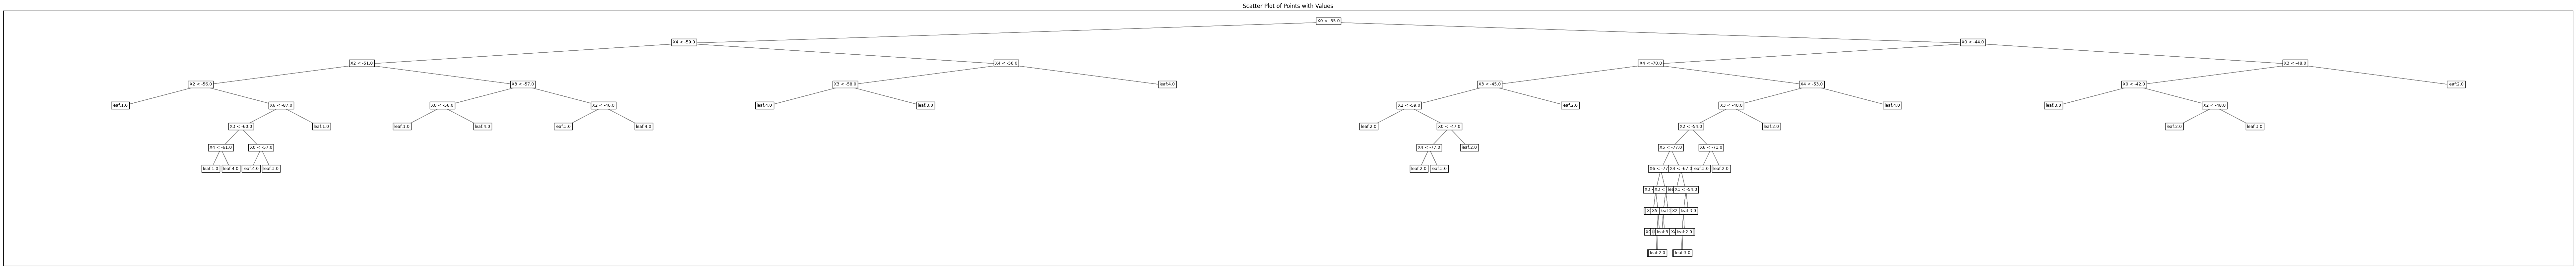

In [46]:
import matplotlib.pyplot as plt

def plot_node_texts(x_coords, y_coords, features, values):
    """
    Plot the text annotations for each node in the decision tree.
    """
    for i, value in enumerate(values):
        if features[i] is None:
            plt.text(
                x_coords[i], y_coords[i], f'leaf:{value}', 
                fontsize=9, ha='center', 
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3}
            )
        else:
            plt.text(
                x_coords[i], y_coords[i], f'X{features[i]} < {value}', 
                fontsize=9, ha='center', 
                bbox={'facecolor': 'white', 'alpha': 1, 'pad': 3}
            )

def plot_arrows(arrows):
    """
    Draw the arrows connecting the nodes in the decision tree.
    """
    for start, end in arrows:
        x_start, y_start = start[0], -start[1]
        x_end, y_end = end[0], -end[1]

        plt.arrow(
            x_start, y_start, x_end - x_start, y_end - y_start,
            head_width=0, head_length=0, fc='gray', ec='gray', 
            length_includes_head=True
        )

def draw_tree(nodes, arrows):
    """
    Function to draw the decision tree.
    """

    x_coords = [point[0] for point in nodes]
    y_coords = [-point[1] for point in nodes]
    features = [point[2] for point in nodes]
    values = [point[3] for point in nodes]

    plt.figure(figsize=(100, 10))
    plt.title('Scatter Plot of Points with Values')
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)

    # Plot arrows and node labels
    plot_node_texts(x_coords, y_coords, features, values)
    plot_arrows(arrows)
  
    plt.grid(True)
    plt.show()

draw_tree(*layout(*decision_tree_learning(data)))

# STEP 3

In [52]:
def traverse_singular(tree, entry) -> int:
    """
    Function to traverse the decision tree and make a prediction for a single entry.
    """

    if 'left' not in tree and 'right' not in tree:
        return tree['value']
    
    if entry[tree['feature']] < tree['value']:
        return traverse_singular(tree['left'], entry)
    
    return traverse_singular(tree['right'], entry)

In [55]:
def single_confusion_matrix_for(tree, data):
    """
    Calculates the confusion matrix for a decision tree on a dataset.
    """  

    confusion_matrix = np.zeros((4,4), dtype=int)

    for entry in data:
        predicted = traverse_singular(tree, entry)
        actual = entry[-1]

        confusion_matrix[int(actual - 1)][int(predicted - 1)] += 1

    return confusion_matrix

In [56]:
def confusion_matrix_for(data):
    np.random.shuffle(data)
    num_splits = 10
    split_size = len(data) // num_splits

    confusion_matrix = np.zeros((4,4), dtype=int)
    
    cm_splits = []

    for i in range(num_splits):
        left = data[:i * split_size]
        test = data[i * split_size: (i+1) * split_size]
        right = data[(i+1) * split_size + num_splits:]

        train = np.concatenate((left, right), axis=0)

        tree, _ = decision_tree_learning(train)

        confusion_matrix += single_confusion_matrix_for(tree, test)

    return confusion_matrix, cm_splits

cm = confusion_matrix_for(data)
print(cm)

[[492   0   5   3]
 [  0 478  22   0]
 [  2  21 473   4]
 [  5   0   2 493]]


In [248]:
def accuracy(confusion_matrix):
    total = np.sum(confusion_matrix)
    correct = np.sum(np.diagonal(confusion_matrix))

    return float(correct / total)

print(f'accuracy: {accuracy(cm)}')

accuracy: 0.968


In [249]:
def precision(confusion_matrix, label):
    tp = confusion_matrix[label - 1][label - 1]
    fp = 0
    for i in range(4):
        if i+1 == label:
            continue
        fp += confusion_matrix[i][label - 1]

    return float(tp / (tp + fp))

In [250]:
def macro_averaged_precision(cms, label):
    sum = 0
    for cm in cms:
        sum += precision(cm, label)
    return sum / len(cms)

for i in range(4):
    print(f'macro_averaged_precision X{i+1}: {macro_averaged_precision(cm_splits, i+1)}')

macro_averaged_precision X1: 0.9860607762755622
macro_averaged_precision X2: 0.9600106047941495
macro_averaged_precision X3: 0.9421221616755824
macro_averaged_precision X4: 0.9833636533820318


In [251]:
def recall(confusion_matrix, label):
    tp = confusion_matrix[label - 1][label - 1]
    fn = 0
    for i in range(4):
        if i+1 == label:
            continue
        fn += confusion_matrix[label - 1][i]

    return float(tp / (tp + fn))

In [252]:
def macro_averaged_recall(cms, label):
    sum = 0
    for cm in cms:
        sum += recall(cm, label)
    return sum / len(cms)

for i in range(4):
    print(f'macro_averaged_recall X{i+1}: {macro_averaged_recall(cm_splits, i+1)}')

macro_averaged_recall X1: 0.9852224990544813
macro_averaged_recall X2: 0.9546716222935206
macro_averaged_recall X3: 0.9493235288012993
macro_averaged_recall X4: 0.98199466265972


In [253]:
def f1(cm, label):
    p = precision(cm, label)
    r = recall(cm, label)
    return (2 * p * r) / (p + r)

In [254]:
def macro_averaged_f1(cms, label):
    sum = 0
    for cm in cms:
        sum += recall(cm, label)
    return sum / len(cms)

for i in range(4):
    print(f'macro_averaged_f1_measure X{i+1}: {macro_averaged_f1(cm_splits, i+1)}')

macro_averaged_f1_measure X1: 0.9852224990544813
macro_averaged_f1_measure X2: 0.9546716222935206
macro_averaged_f1_measure X3: 0.9493235288012993
macro_averaged_f1_measure X4: 0.98199466265972
